In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# <center> **Hello World**
This tutorial/example aims to give an **simplistic overview** of setting up a **passive volume** (scattering material to be imaged), **detector** (active material to record hits), and **optimisation loop** (to refine the detector to image the passive volume better or more cheaply).

The differences with the main TomOpt package will be highlighted.

## **Volume setup**

The **volume** consists of both **passive material** to be imaged, and **active detectors** to **record** **muons** hits. We aim to adjust the position the detectors to improve the precision of the imaging of the passive volume.

In [2]:
from tomopt.core import *

In [3]:
import torch
from torch import Tensor
from torch.nn import functional as F

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DEVICE = torch.device('cpu')

The default TomOpt's implementaion is designed for the optimisation of independent detection panels. Each of them have a set of **free parameters**: **position** and **span**.

This branch of TomOtp is designed to optimize the layout of detection modules called **hodoscopes**, which themselves contain detection planes with **fixed span**. Each hodoscope then only has 3 free parameters: its $x$, $y$ and $z$ position.

The **hodoscope** is parametrized as follow:

 - `init_xyz`: The initial position of the top (along $z$) center (along $xy$) of the hodoscope.
 - `init_span`: The initial span of the hodoscope in $xyz$.
 - `n_panels`: The number of detector panels to be placed within the hodoscope.
 - `xyz_gap`: The gap between the edges of the hodoscope and the detector panels along $xyz$.
 - `eff`: The individual panels efficiency
 - `res`: The inverse panels spatial resolution $\frac{1}{\sigma}$ in $m^{-1}$

In [5]:
import sys
sys.path.insert(1, '../')
from volume.hodoscope import Hodoscope

hod = Hodoscope(
    init_xyz= [.5, .5, 1.], # Position x,y,z in meters
    init_xyz_span = [1.5 , 1.5, .4], # Detection panels span dx, dy, dz im meters
    xyz_gap = [.1, .1, .1], # Gap between panels and 
    eff = 0.9, # Muon detection per panel efficiency
    res = 1e4 # Detection panels 
    )

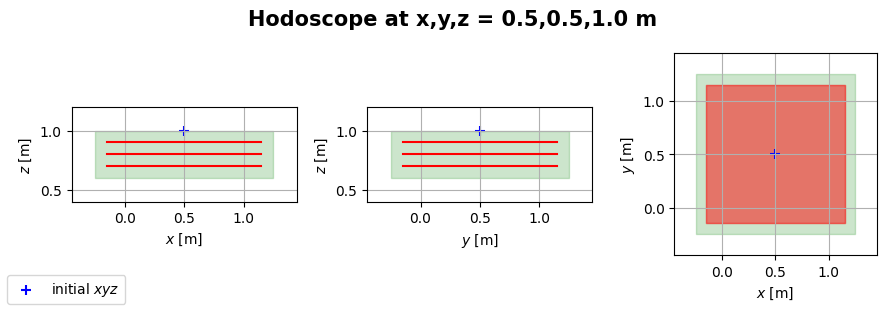

In [7]:
hod.draw()

One can construct a **volume** by sandwiching **passive layers** with **pairs** of **hodoscope detector layers above and below**. 

In [8]:
init_xyz_span, xyz_gap = [1.5, 1.5, 0.3], [0.1, 0.1, 0.1]
init_eff, init_res = 0.90, 1e3

hods = [
    Hodoscope(
        init_xyz = [0.5, 0.5, z],
        init_xyz_span = init_xyz_span,
        xyz_gap = xyz_gap,
        eff = init_eff,
        res = init_res,
    ) for z in [1.3, 1.]
]

The `HodoscopeDetectorLayer` class takes the following arguments:

 - `pos`: Tag defining the position of the layer w.r.t the passive volume (either `above` or `below`)
 - `lw`: Length and width of the layer in the $x$ and $y$ axes in metres, starting from (x,y)=(0,0).
 - `z`: $z$ position of the top of the layer.
 - `size`: Distance from the top to bottom of the layer.
 - `hodoscopes`: Hodoscopes to be contained in the layer. 

In [9]:
from volume.hodoscopelayer import HodoscopeDetectorLayer

# Above detector layer
layer_above = HodoscopeDetectorLayer(
        pos = "above", 
        lw = Tensor([2, 2]), 
        z = 1.0, 
        size = 0.5, 
        hodoscopes=hods
    )

In [18]:
hods = [
    Hodoscope(
        init_xyz = [0.5, 0.5, z],
        init_xyz_span = init_xyz_span,
        xyz_gap = xyz_gap,
        eff = init_eff,
        res = init_res,
    ) for z in [-0.1, -0.4]
]

# Below detector layer
layer_below = HodoscopeDetectorLayer(
        pos = "above", 
        lw = Tensor([2, 2]), 
        z = 0.0, 
        size = 0.5, 
        hodoscopes=hods
    )

The **hodoscope** and **passive** **layers** are then sandwiched together:

In [19]:
from torch import nn
from tomopt.volume import PassiveLayer

def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1, 1, 1])
        size = 0.1
        # Above hodoscope layer
        layers.append(hod_layers[0])

        # Passive layers
        for z in [0.7, 0.6, 0.5, 0.4, 0.3]:
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
        
        # Below detector layers
        layers.append(hod_layers[1])

        return nn.ModuleList(layers)

We''ll feed these stacked layers into a single object for convience:

In [20]:
from tomopt.volume import Volume
volume = Volume(get_layers([layer_above, layer_below]))
volume

Volume(
  (layers): ModuleList(
    (0): HodoscopeDetectorLayer(
      (hodoscopes): ModuleList(
        (0): Hodoscope located at z = 1.30 m
        (1): Hodoscope located at z = 1.00 m
      )
    )
    (1): PassiveLayer located at z=tensor([0.7000])
    (2): PassiveLayer located at z=tensor([0.6000])
    (3): PassiveLayer located at z=tensor([0.5000])
    (4): PassiveLayer located at z=tensor([0.4000])
    (5): PassiveLayer located at z=tensor([0.3000])
    (6): HodoscopeDetectorLayer(
      (hodoscopes): ModuleList(
        (0): Hodoscope located at z = -0.10 m
        (1): Hodoscope located at z = -0.40 m
      )
    )
  )
)

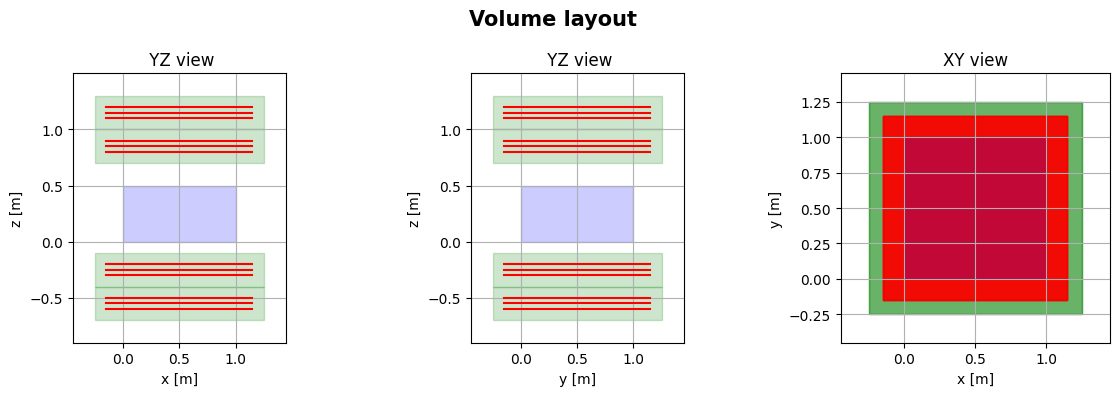

In [28]:
from plotting.plotting import draw_volume_2D
draw_volume_2D(volume, savename="/home/geant/Desktop/test")

## Optimisation

Having built our **detector** and defined where the **passive volumes** will be, we now want to define the **material** **composition** of the **passive volume**(s) to be imaged, and to optimise our detector.


As its name suggests, `PanelVolumeWrapper` wraps the `Volume` and **provides methods** to **optimise the detector**, **predict** passive volumes, loading and saving of detector configurations, etc.

When building the wrapper, we need to supply it with **optimiser definitions** for both **resolution** and **efficiency**, and a **loss function** to optimise. 

Optimisers are the classes in PyTorch which implement gradient descent on specified parameters. For the optimisers, use partial definitions, since the `PanelVolumeWrapper` takes care of instantiating the optimisers to relate to the relevant detector parameters. Although we set some learning rates (`lr`) here, it is difficult to know a priori what are suitable values. When running the optimisation, though, we will use a special callback to set more suitable values.

In [ ]:
from functools import partial
from tomopt.optimisation import PanelVolumeWrapper, VoxelX0Loss